In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# Data

In [13]:
data = pd.read_csv('bio_train.csv', header=None)  # Ensure the file name and path are correct
filtered_data = data.groupby(0).apply(lambda x: x.head(40)).reset_index(drop=True)

# Now 'filtered_data' contains 10 entries for each BLOCK ID
X = filtered_data.iloc[:, 3:].values  # Feature columns
true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Lloyd’s algorithm for k-Means Clustering 

In [9]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [ ]:
k = 153
max_iters = 1000

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans(X_scaled, k, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

In [ ]:
plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

In [ ]:
# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



In [ ]:
# Assuming `all_distance_calculations` contains the number of distance calculations for each of the five runs
# Distance calculations data and calculation of average
average_distances = np.mean(all_distance_calculations)

# Create a plot for distance calculations with custom colors
plt.figure(figsize=(10, 6))
plt.bar(range(1, 7), all_distance_calculations + [average_distances], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Number of Distance Calculations')
plt.title('Distance Calculations for Each Run and Average')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [16]:
import numpy as np
from tqdm import tqdm
import time

# Define the LSH function
def lsh_hash_function(a, b, w):
    def hash_func(p):
        return np.floor((np.dot(a, p) + b) / w)
    return hash_func

# Initialize LSH parameters
def initialize_lsh(X, num_hashes, w):
    n, d = X.shape
    a = np.random.randn(num_hashes, d)
    b = np.random.uniform(0, w, num_hashes)
    hash_funcs = [lsh_hash_function(a[i], b[i], w) for i in range(num_hashes)]
    return hash_funcs

# Compute hash values for all data points
def compute_lsh_hashes(X, hash_funcs):
    hashes = np.array([[h(p) for h in hash_funcs] for p in X])
    return hashes

# Custom K-means functions
def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters_lsh(X, centroids, hashes, hash_funcs):
    n_samples = X.shape[0]
    labels = np.empty(n_samples, dtype=int)
    
    # Compute centroid hashes
    centroid_hashes = compute_lsh_hashes(centroids, hash_funcs)
    
    for i, point_hash in enumerate(hashes):
        # Check which centroids share the same hash value
        potential_centroids = np.all(centroid_hashes == point_hash, axis=1)
        if np.any(potential_centroids):
            distances = np.sqrt(((X[i] - centroids[potential_centroids])**2).sum(axis=1))
            labels[i] = np.argmin(distances)
        else:
            # If no hash match, fall back to calculating distances to all centroids
            distances = np.sqrt(((X[i] - centroids)**2).sum(axis=1))
            labels[i] = np.argmin(distances)
    
    return labels

def update_centroids(X, labels, k):
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids

def kmeans_lsh(X, k, num_hashes=10, w=4.0, max_iters=500):
    centroids = initialize_centroids(X, k)
    hash_funcs = initialize_lsh(X, num_hashes, w)
    hashes = compute_lsh_hashes(X, hash_funcs)
    
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters_lsh(X, centroids, hashes, hash_funcs)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 500

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_lsh(X, k, num_hashes=25, w=4.0, max_iters=max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



K-means Iteration:   0%|          | 0/5000 [00:00<?, ?it/s]c:\Program Files\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (151) found smaller than n_clusters (153). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
K-means Iteration:   0%|          | 1/5000 [00:00<12:48,  6.50it/s]c:\Program Files\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (152) found smaller than n_clusters (153). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
K-means Iteration:   0%|          | 0/5000 [00:00<?, ?it/s]c:\Program Files\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (152) found smaller than n_clusters (153). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
K-means Iteration:   1%|          | 35/5000 [00:04<09:41,  8.53it/s]


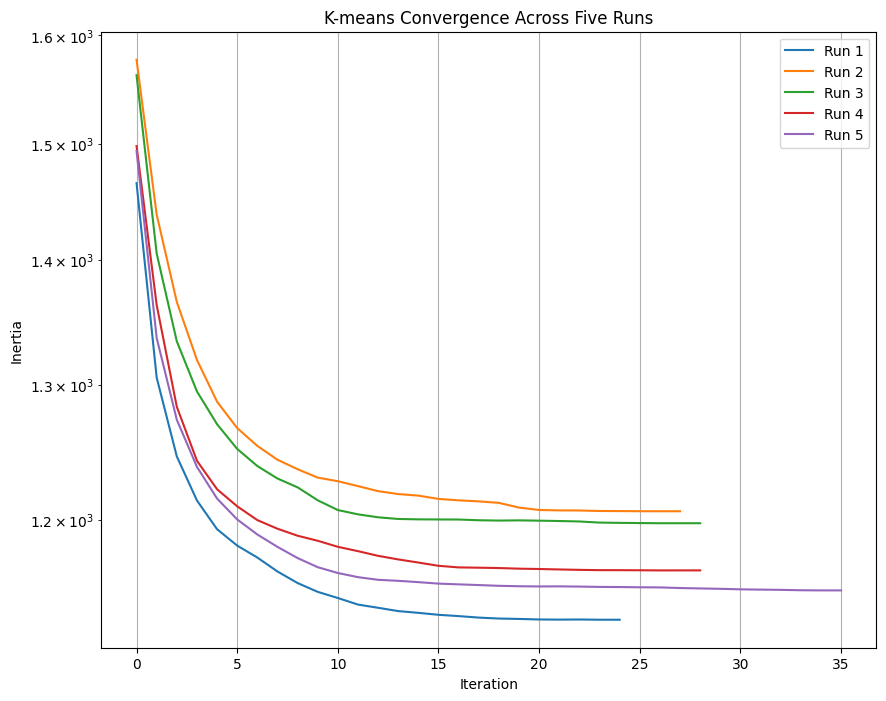

Average NMI Score over five runs: 0.1208


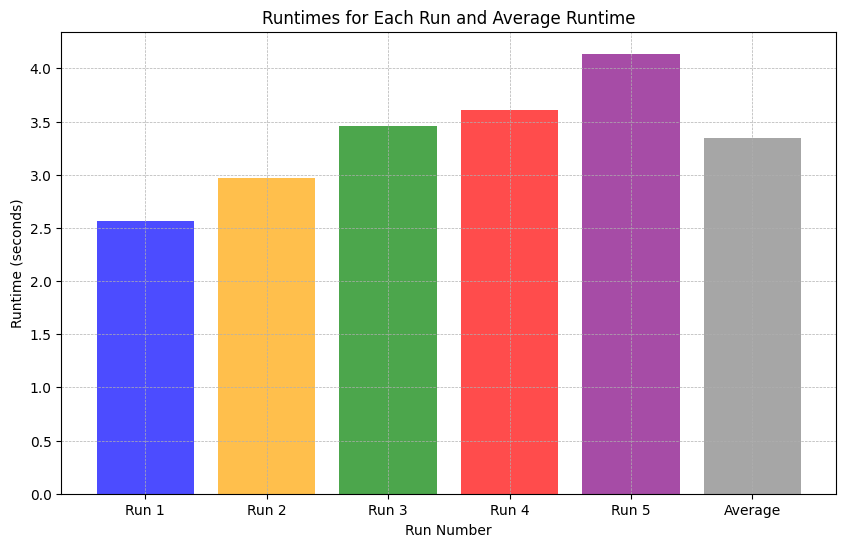

In [25]:
import numpy as np
from tqdm import tqdm
import time
from sklearn.cluster import KMeans

def compute_coreset(X, m):
    """
    Compute the coreset for K-means clustering.
    Args:
    - X: The original data points.
    - m: The number of samples in the coreset.

    Returns:
    - S: The coreset samples.
    - weights: The weights of the coreset samples.
    """
    n, d = X.shape
    kmeans = KMeans(n_clusters=min(10, n // 2)).fit(X)  # Initial clustering
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Compute importance sampling probabilities
    distances = np.linalg.norm(X - centers[labels], axis=1)
    total_distances = np.sum(distances)
    probabilities = distances / total_distances

    # Sample points to form the coreset
    coreset_indices = np.random.choice(n, m, p=probabilities)
    S = X[coreset_indices]
    weights = 1 / (probabilities[coreset_indices] * m)
    
    return S, weights

def assign_clusters(X, centroids):
    """
    Assign data points to the nearest centroid.
    Args:
    - X: The data points.
    - centroids: The current centroids.

    Returns:
    - labels: The assigned cluster labels.
    """
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels

def update_centroids(X, labels, k):
    """
    Update centroids as the mean of assigned data points.
    Args:
    - X: The data points.
    - labels: The assigned cluster labels.
    - k: The number of clusters.

    Returns:
    - new_centroids: The updated centroids.
    """
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans_with_coreset(X, k, m, max_iters=5000):
    """
    Perform K-means clustering using coresets.
    Args:
    - X: The original data points.
    - k: The number of clusters.
    - m: The number of samples in the coreset.
    - max_iters: The maximum number of iterations.

    Returns:
    - centroids: The cluster centers.
    - labels: The labels of the original data points.
    - iters: The number of iterations run.
    - inertia_history: The history of inertia values.
    - total_distance_calculations: The total number of distance calculations.
    - runtime: The total runtime of the algorithm.
    """
    start_time = time.time()
    
    # Compute the coreset
    S, weights = compute_coreset(X, m)
    
    # Perform weighted K-means on the coreset
    centroids = initialize_centroids(S, k)
    inertia_history = []
    total_distance_calculations = 0

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        kmeans = KMeans(n_clusters=k, max_iter=1, init=centroids, n_init=1).fit(S, sample_weight=weights)
        new_centroids = kmeans.cluster_centers_
        labels = assign_clusters(X, new_centroids)
        
        inertia = np.sum((X - new_centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k
        
        if np.allclose(centroids, new_centroids, atol=1e-6):
            break
        centroids = new_centroids
    
    runtime = time.time() - start_time
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 500

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
m_values = [100, 1000, 10000]

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_with_coreset(X, k, m)

    # Append results to lists
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
